In [2]:
import numpy as np
import pandas as pd
import pylibjpeg
import pydicom
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from multiprocessing import cpu_count

import cv2
import glob
import importlib
import os
import joblib
import sys
import dicomsdl
import dotenv
dotenv.load_dotenv()

tf.config.threading.set_inter_op_parallelism_threads(num_threads=int(os.environ['TF_THREADS']))
cv2.setNumThreads(int(os.environ['CV_THREADS']))

16

In [ ]:
TARGET_HEIGHT = int(os.environ['TARGET_HEIGHT'])
TARGET_WIDTH = int(os.environ['TARGET_WIDTH'])
TARGET_HEIGHT_WIDTH_RATIO = TARGET_HEIGHT / TARGET_WIDTH
APPLY_CLAHE = False
APPLY_EQ_HIST = False
CLAHE = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32, 32))
IMAGE_FORMAT = os.environ['IMAGE_FORMAT']
IMAGE_QUALITY = int(os.environ['IMAGE_QUALITY'])
N_CHANNELS = int(os.environ['N_CHANNELS'])

# MatplotLib Global Settings
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

In [12]:
train = pd.read_csv('../data/train.csv')

def get_file_path(args):
    patient_id, image_id = args
    return f'../train_images/{patient_id}/{image_id}.dcm'

train['filepath'] = train[['patient_id', 'image_id']].apply(get_file_path, axis=1)

display(train.info())
display(train.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
 14  filepath              

None

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
0         0     NaN        0     NaN          29                    False   
1         0     NaN        0     NaN          29                    False   
2         0     NaN        0     NaN          29                    False   

                               filepath  
0   ../train_images/10006/462822612.dcm  
1  ../train_images/10006/1459541791.dcm  
2  ../train_images/10006/1864590858.dcm

In [13]:
# Source: https://www.kaggle.com/code/bobdegraaf/dicomsdl-voi-lut
def voi_lut(image, dicom):
    # Load only the variables we need
    center = dicom['WindowCenter']
    width = dicom['WindowWidth']
    bits_stored = dicom['BitsStored']
    voi_lut_function = dicom['VOILUTFunction']

    # For sigmoid it's a list, otherwise a single value
    if isinstance(center, list):
        center = center[0]
    if isinstance(width, list):
        width = width[0]

    # Set y_min, max & range
    y_min = 0
    y_max = float(2**bits_stored - 1)
    y_range = y_max

    # Function with default LINEAR (so for Nan, it will use linear)
    if voi_lut_function == 'SIGMOID':
        image = y_range / (1 + np.exp(-4 * (image - center) / width)) + y_min
    else:
        # Checks width for < 1 (in our case not necessary, always >= 750)
        center -= 0.5
        width -= 1

        below = image <= (center - width / 2)
        above = image > (center + width / 2)
        between = np.logical_and(~below, ~above)

        image[below] = y_min
        image[above] = y_max
        if between.any():
            image[between] = (
                ((image[between] - center) / width + 0.5) * y_range + y_min
            )

    # Normalize to have 0 as background, some images are reversed where 0 is max intensity
    if dicom['PhotometricInterpretation'] == 'MONOCHROME1':
        image = np.max(image) - image

    return image

In [14]:
# Smooth vector used to smoothen sums/stds of axes
def smooth(l):
    # kernel size is 1% of vector
    kernel_size = int(len(l) * 0.01)
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(l, kernel, mode='same')

# X Crop offset based on first column with sum below 5% of maximum column sums*std
def get_x_offset(image, max_col_sum_ratio_threshold=0.05, debug=None):
    # Image Dimensions
    H, W = image.shape
    # Percentual margin added to offset
    margin = int(image.shape[1] * 0.00)
    # Threshold values based on smoothed sum x std to capture varying intensity columns
    vv = smooth(image.sum(axis=0).squeeze()) * smooth(image.std(axis=0).squeeze())
    # Find maximum sum in first 75% of columns
    vv_argmax = vv[:int(image.shape[1] * 0.75)].argmax()
    # Threshold value
    vv_threshold = vv.max() * max_col_sum_ratio_threshold
    
    # Find first column after maximum column below threshold value
    for offset, v in enumerate(vv):
        # Start searching from vv_argmax
        if offset < vv_argmax:
            continue
        
        # Column below threshold value found
        if v < vv_threshold:
            offset = min(W, offset + margin)
            break
            
    if isinstance(debug, np.ndarray):
        debug[1].imshow(image)
        debug[1].set_title('X Offset')
        vv_scale = H / vv.max() * 0.90
        # Values
        debug[1].plot(H - vv * vv_scale , c='red', label='vv')
        # Threshold
        debug[1].hlines(H - vv_threshold * vv_scale, 0, W -1, colors='orange', label='threshold')
        # Max Value
        debug[1].scatter(vv_argmax, H - vv[vv_argmax] * vv_scale, c='blue', s=100, label='Max', zorder=np.PINF)
        # First Column Below Threshold
        debug[1].scatter(offset, H - vv[offset] * vv_scale, c='purple', s=100, label='Offset', zorder=np.PINF)
        debug[1].set_ylim(H, 0)
        debug[1].legend()
        debug[1].axis('off')
        
    return offset

# Y Crop offset based on first bottom and top rows with sum below 10% of maximum row sum*std
def get_y_offsets(image, max_row_sum_ratio_threshold=0.10, debug=None):
    # Image Dimensions
    H, W = image.shape
    # Margin to add to offsets
    margin = 0
    # Threshold values based on smoothed sum x std to capture varying intensity columns
    vv = smooth(image.sum(axis=1).squeeze()) * smooth(image.std(axis=1).squeeze())
    # Find maximum sum * std row in inter quartile rows
    vv_argmax = int(image.shape[0] * 0.25) + vv[int(image.shape[0] * 0.25):int(image.shape[0] * 0.75)].argmax()
    # Threshold value
    vv_threshold = vv.max() * max_row_sum_ratio_threshold
    # Default crop offsets
    offset_bottom = 0
    offset_top = H

    # Bottom offset, search from argmax to bottom
    for offset in reversed(range(0, vv_argmax)):
        v = vv[offset]
        if v < vv_threshold:
            offset_bottom = offset
            break
    
    if isinstance(debug, np.ndarray):
        debug[2].imshow(image)
        debug[2].set_title('Y Bottom Offset')
        vv_scale = W / vv.max() * 0.90
        # Values
        debug[2].plot(vv * vv_scale, np.arange(H), c='red', label='vv')
        # Threshold
        debug[2].vlines(vv_threshold * vv_scale, 0, H -1, colors='orange', label='threshold')
        # Max Value
        debug[2].scatter(vv[vv_argmax] * vv_scale, vv_argmax, c='blue', s=100, label='Max', zorder=np.PINF)
        # First Column Below Threshold
        debug[2].scatter(vv[offset_bottom] * vv_scale, offset_bottom, c='purple', s=100, label='Offset', zorder=np.PINF)
        debug[2].set_ylim(H, 0)
        debug[2].legend()
        debug[2].axis('off')
            
    # Top offset, search from argmax to top
    for offset in range(vv_argmax, H):
        v = vv[offset]
        if v < vv_threshold:
            offset_top = offset
            break
            
    if isinstance(debug, np.ndarray):
        debug[3].imshow(image)
        debug[3].set_title('Y Top Offset')
        vv_scale = W / vv.max() * 0.90
        # Values
        debug[3].plot(vv * vv_scale, np.arange(H) , c='red', label='vv')
        # Threshold
        debug[3].vlines(vv_threshold * vv_scale, 0, H -1, colors='orange', label='threshold')
        # Max Value
        debug[3].scatter(vv[vv_argmax] * vv_scale, vv_argmax, c='blue', s=100, label='Max', zorder=np.PINF)
        # First Column Below Threshold
        debug[3].scatter(vv[offset_top] * vv_scale, offset_top, c='purple', s=100, label='Offset', zorder=np.PINF)
        debug[2].set_ylim(H, 0)
        debug[3].legend()
        debug[3].axis('off')
            
    return max(0, offset_bottom - margin), min(image.shape[0], offset_top + margin)

# Crop image and pad offsets to target image height/width ratio to preserve information
def crop(image, size=None, debug=False):
    # Image dimensions
    H, W = image.shape
    # Compute x/bottom/top offsets
    x_offset = get_x_offset(image, debug=debug)
    offset_bottom, offset_top = get_y_offsets(image[:,:x_offset], debug=debug)
    # Crop Height and Width
    h_crop = offset_top - offset_bottom
    w_crop = x_offset
    
    # Pad crop offsets to target aspect ratio
    if size is not None:
        # Height too large, pad x offset
        if (h_crop / w_crop) > TARGET_HEIGHT_WIDTH_RATIO:
            x_offset += int(h_crop / TARGET_HEIGHT_WIDTH_RATIO - w_crop)
        else:
            # Height too small, pad bottom/top offsets
            offset_bottom -= int(0.50 * (w_crop * TARGET_HEIGHT_WIDTH_RATIO - h_crop))
            offset_bottom_correction = max(0, -offset_bottom)
            offset_bottom += offset_bottom_correction

            offset_top += int(0.50 * (w_crop * TARGET_HEIGHT_WIDTH_RATIO - h_crop))
            offset_top += offset_bottom_correction
        
    # Crop Image
    image = image[offset_bottom:offset_top:,:x_offset]
        
    return image

In [15]:
def process(filepath, size=None, dicom_process=True, ret_target=False, crop_image=False, apply_clahe=APPLY_CLAHE, apply_eq_hist=APPLY_EQ_HIST, debug=False):
    # Read Dicom File
    dicom = dicomsdl.open(filepath)
    image = dicom.pixelData()
    
    # Save original image for debug purposes
    if debug:
        fig, axes = plt.subplots(1, 5, figsize=(20,10))
        image0 = np.copy(image)
        axes[0].imshow(image0)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
    else:
        axes = False
        
    # voi_lut
    image = voi_lut(image, dicom)

    # Normalize [0,1] range
    image = (image - image.min()) / (image.max() - image.min())

    # Convert to uint8 image in range [0, 255]
    image = (image * 255).astype(np.uint8)
    
    # Normalize to left/right orientation by flipping right/left oriented images
    h0, w0 = image.shape
    if image[:,int(-w0 * 0.10):].sum() > image[:,:int(w0 * 0.10)].sum():
        image = np.flip(image, axis=1)
    
    if crop_image:
        image = crop(image, size=size, debug=axes)
    
    # Resize
    if size is not None:
        # Pad black pixels to get correct image ratios
        h, w = image.shape
        if (h / w) > TARGET_HEIGHT_WIDTH_RATIO:
            pad = int(h / TARGET_HEIGHT_WIDTH_RATIO - w)
            image = np.pad(image, [[0,0], [0, pad]])
            h, w = image.shape
        else:
            pad = int(0.50 * (w * TARGET_HEIGHT_WIDTH_RATIO - h))
            image = np.pad(image, [[pad, pad], [0,0]])
            h, w = image.shape
        # Resize
        image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
        
    # Apply CLAHE contrast enhancement
    # https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
    if apply_clahe:
        image = CLAHE.apply(image)
        
    # Apply Histogram Equalization
    # https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
    if apply_eq_hist:
        image = cv2.equalizeHist(image)
        
    if debug:
        axes[4].imshow(image)
        axes[4].set_title('Processed Image')
        axes[4].axis('off')
        plt.show()

    # Return Cancer Target
    if ret_target:
        patient_id = int(filepath.split('/')[-2])
        image_id = int(filepath.split('/')[-1].split('.')[0])

        target = PATIENT_ID_IMAGE_ID2CANCER[(patient_id, image_id)]
        
        return image, target
    # Return image Only
    else:
        if debug:
            return image0, image
        else:
            return image

  0%|          | 0/5 [00:00<?, ?it/s]

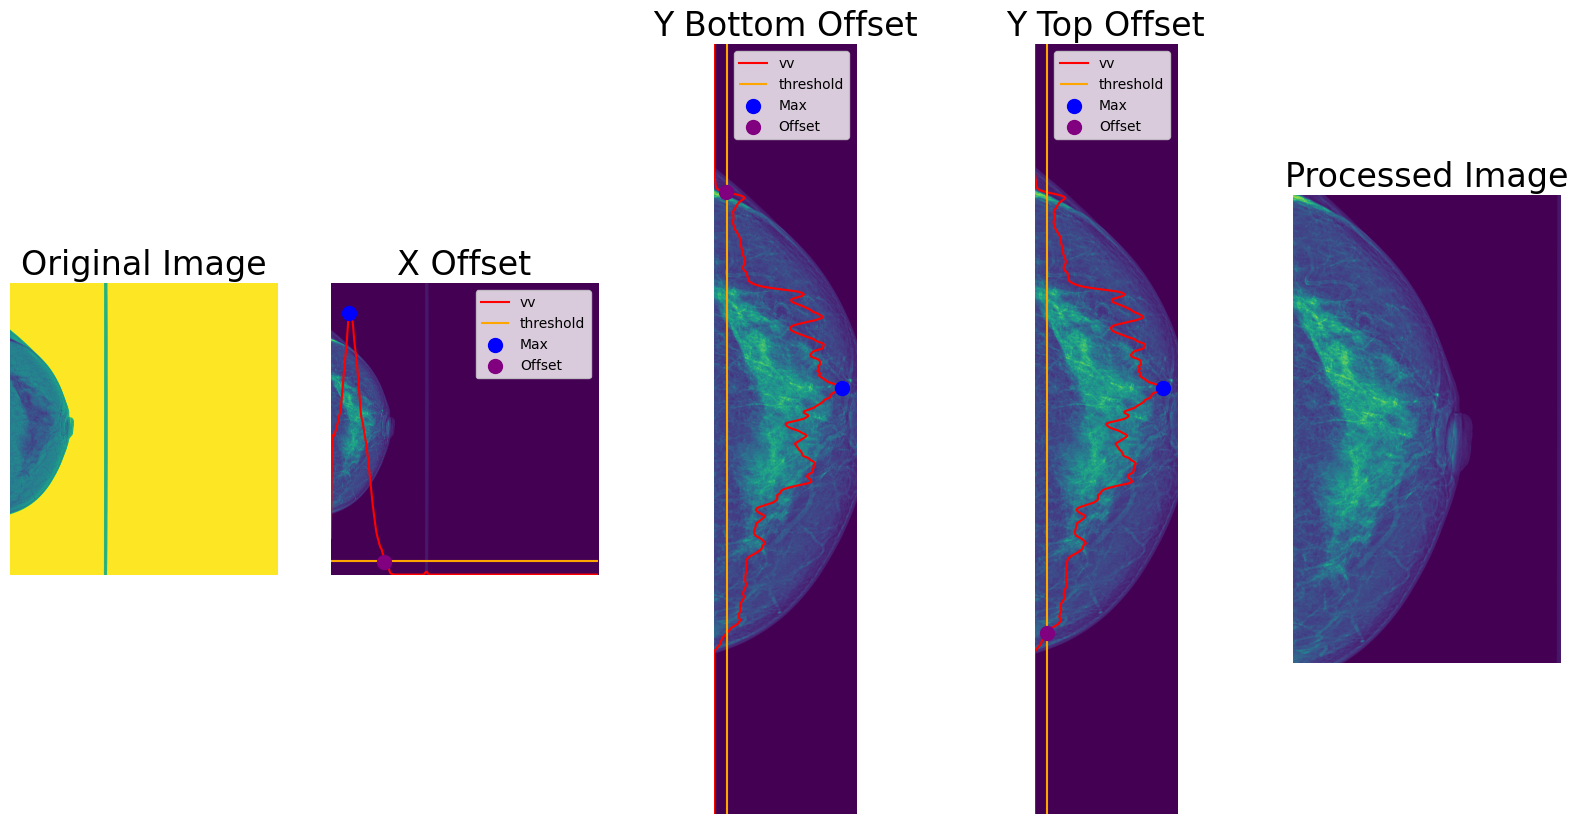

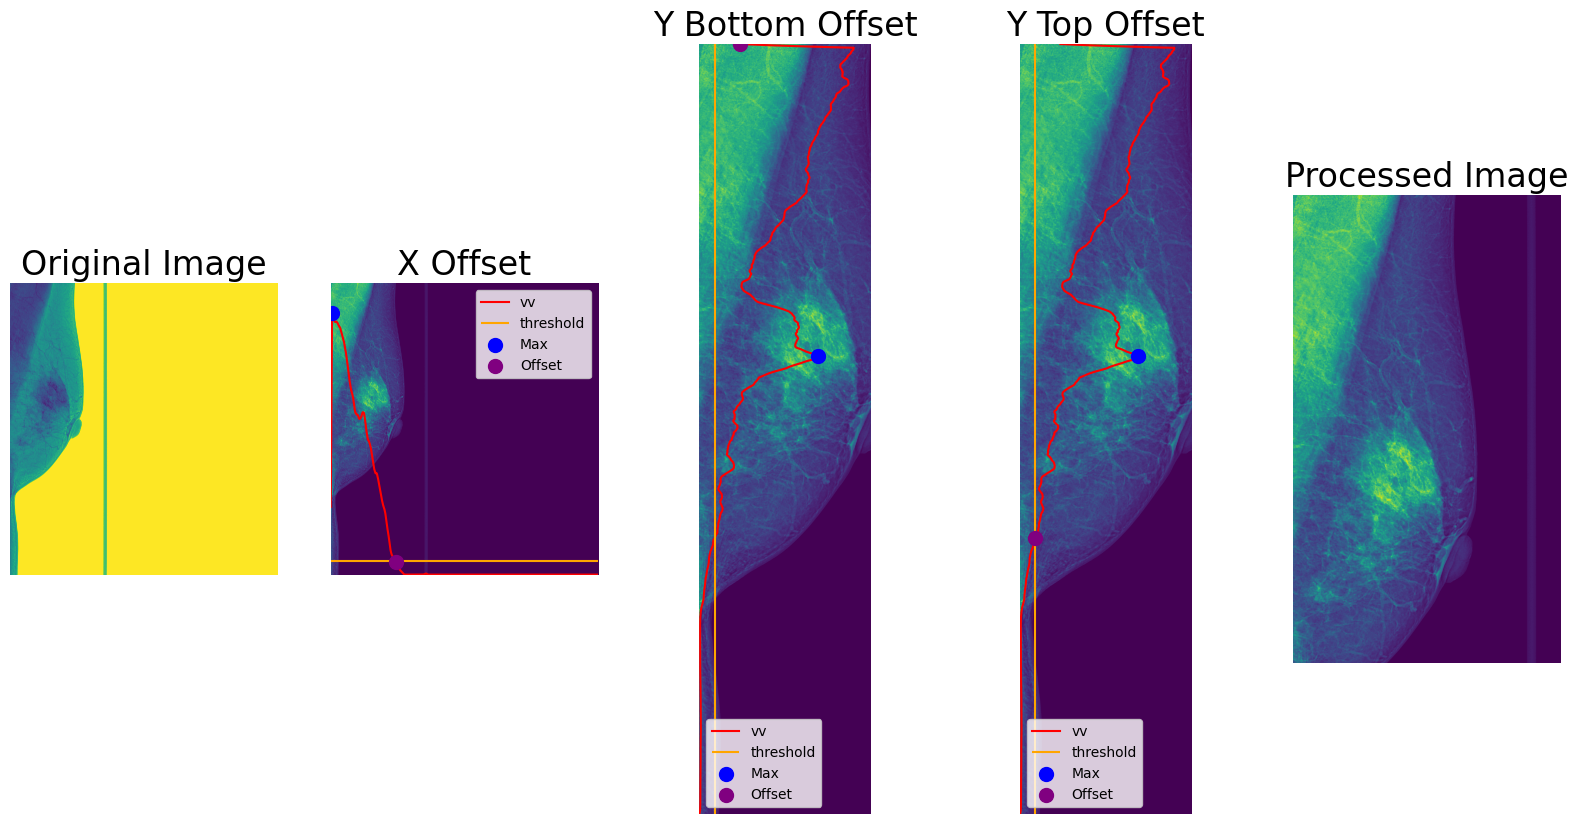

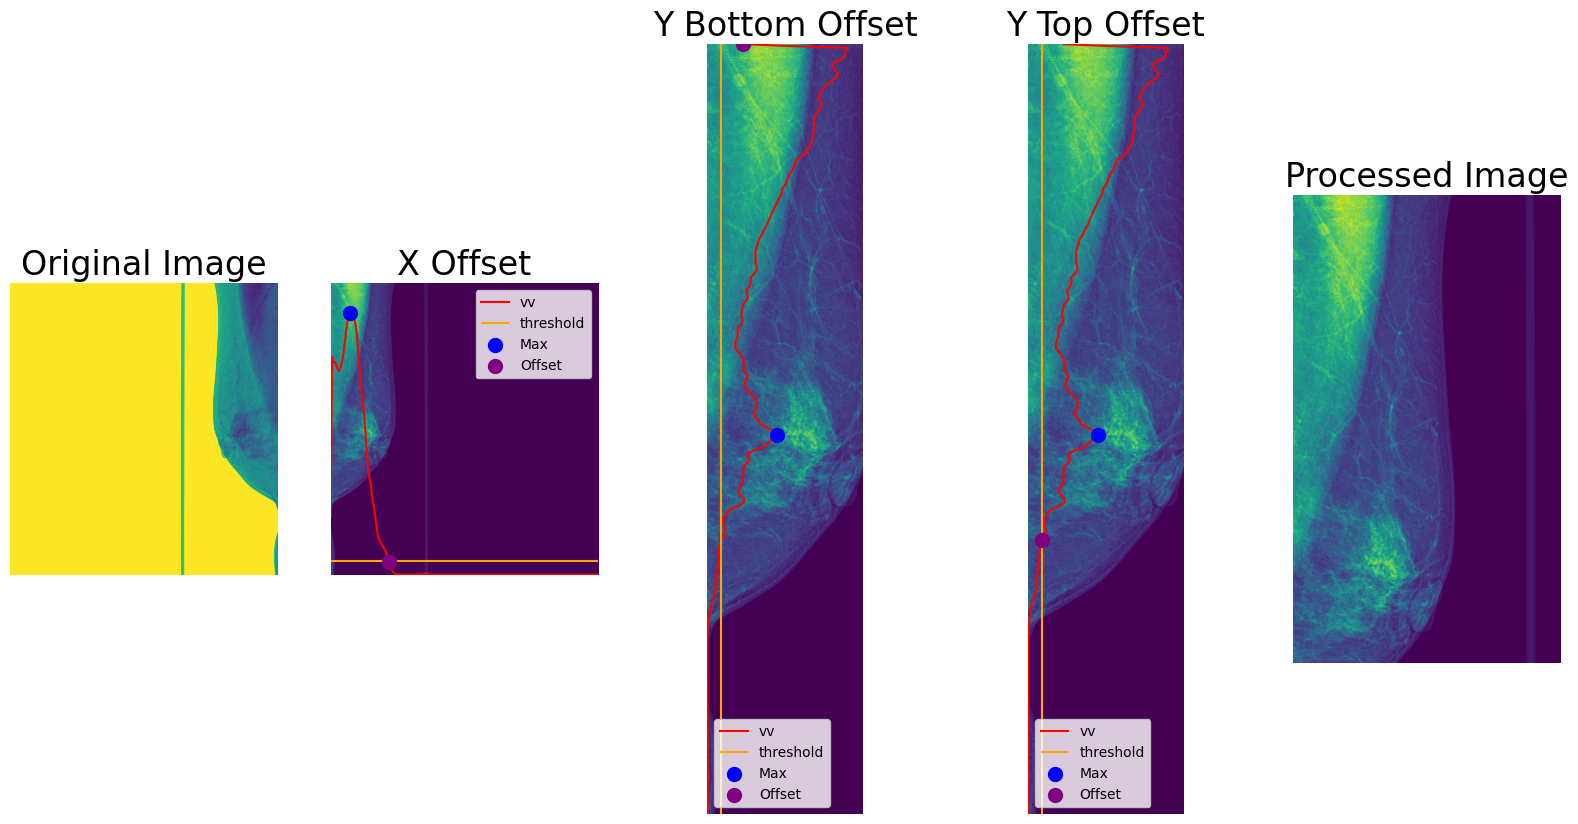

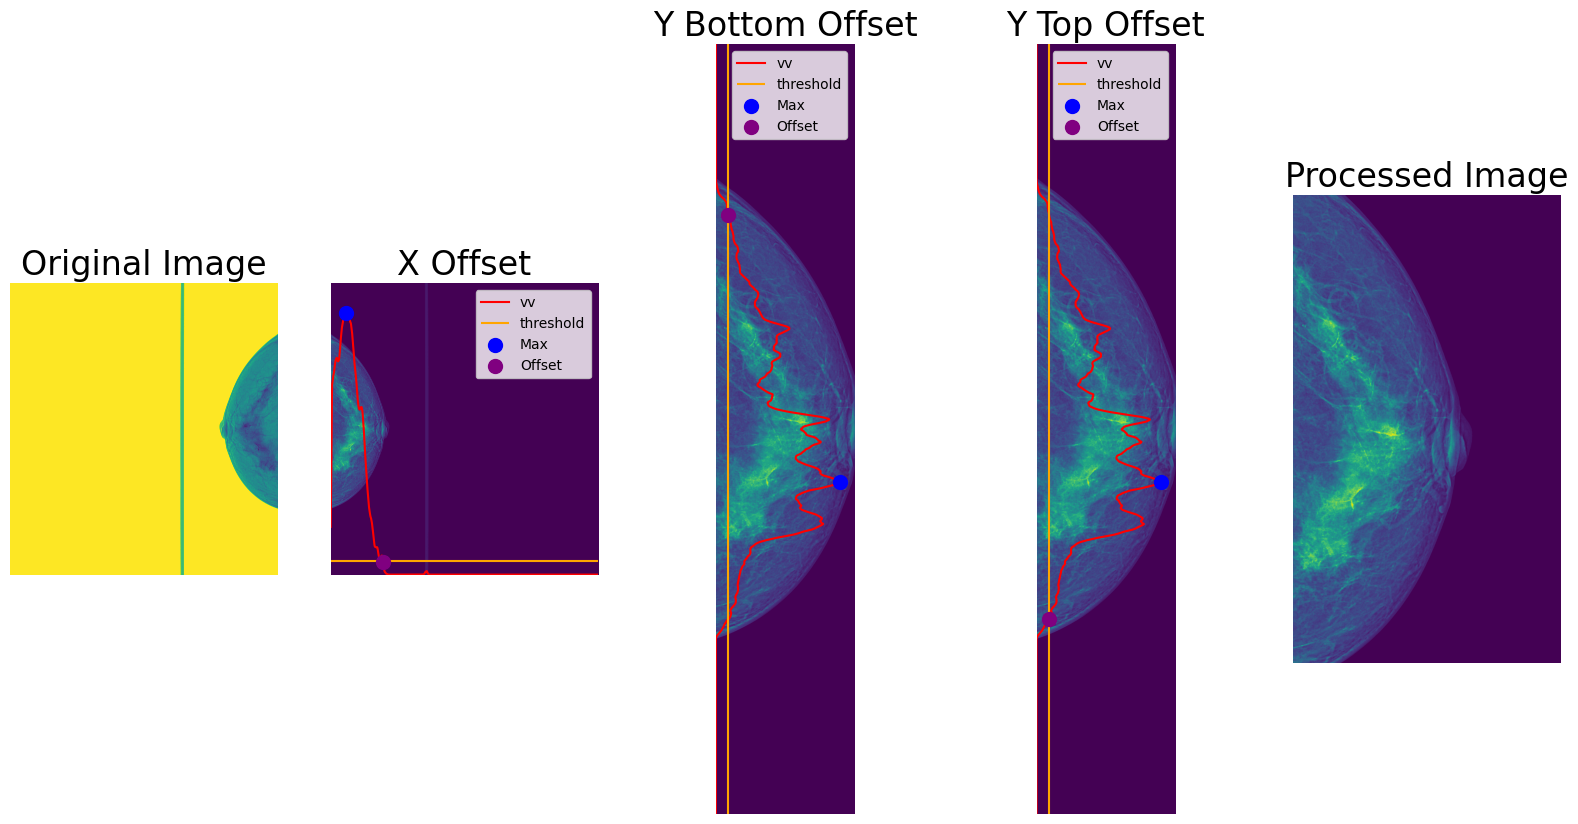

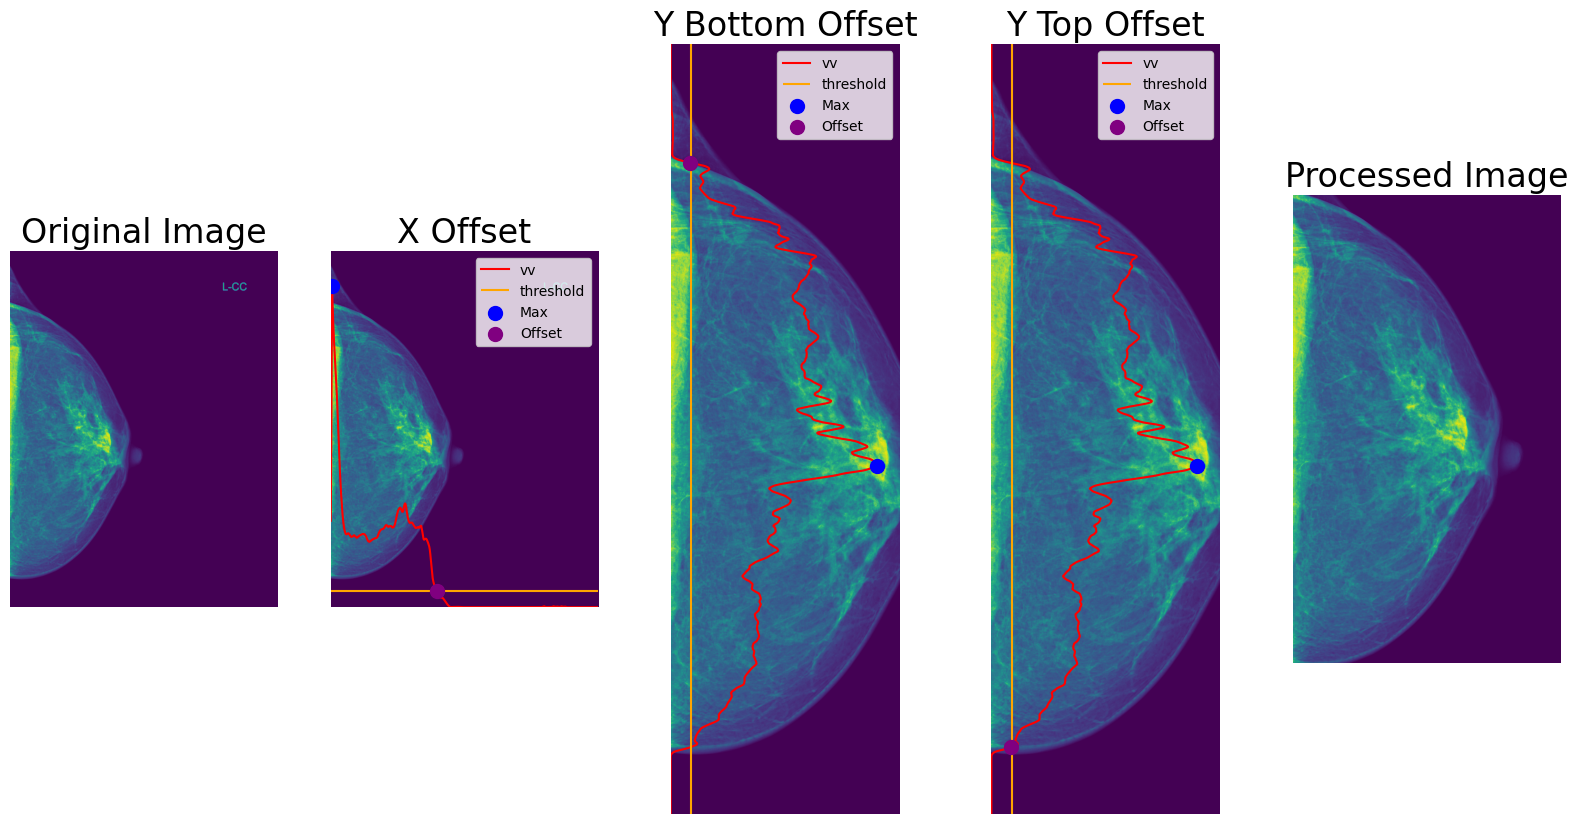

In [16]:
N = 5
for fp in tqdm(train['filepath'].head(N)):
    process(
            fp,
            crop_image=True,
            size=(int(os.environ['TARGET_WIDTH']), int(os.environ['TARGET_HEIGHT'])),
            debug=True,
        )

  0%|          | 0/8 [00:00<?, ?it/s]

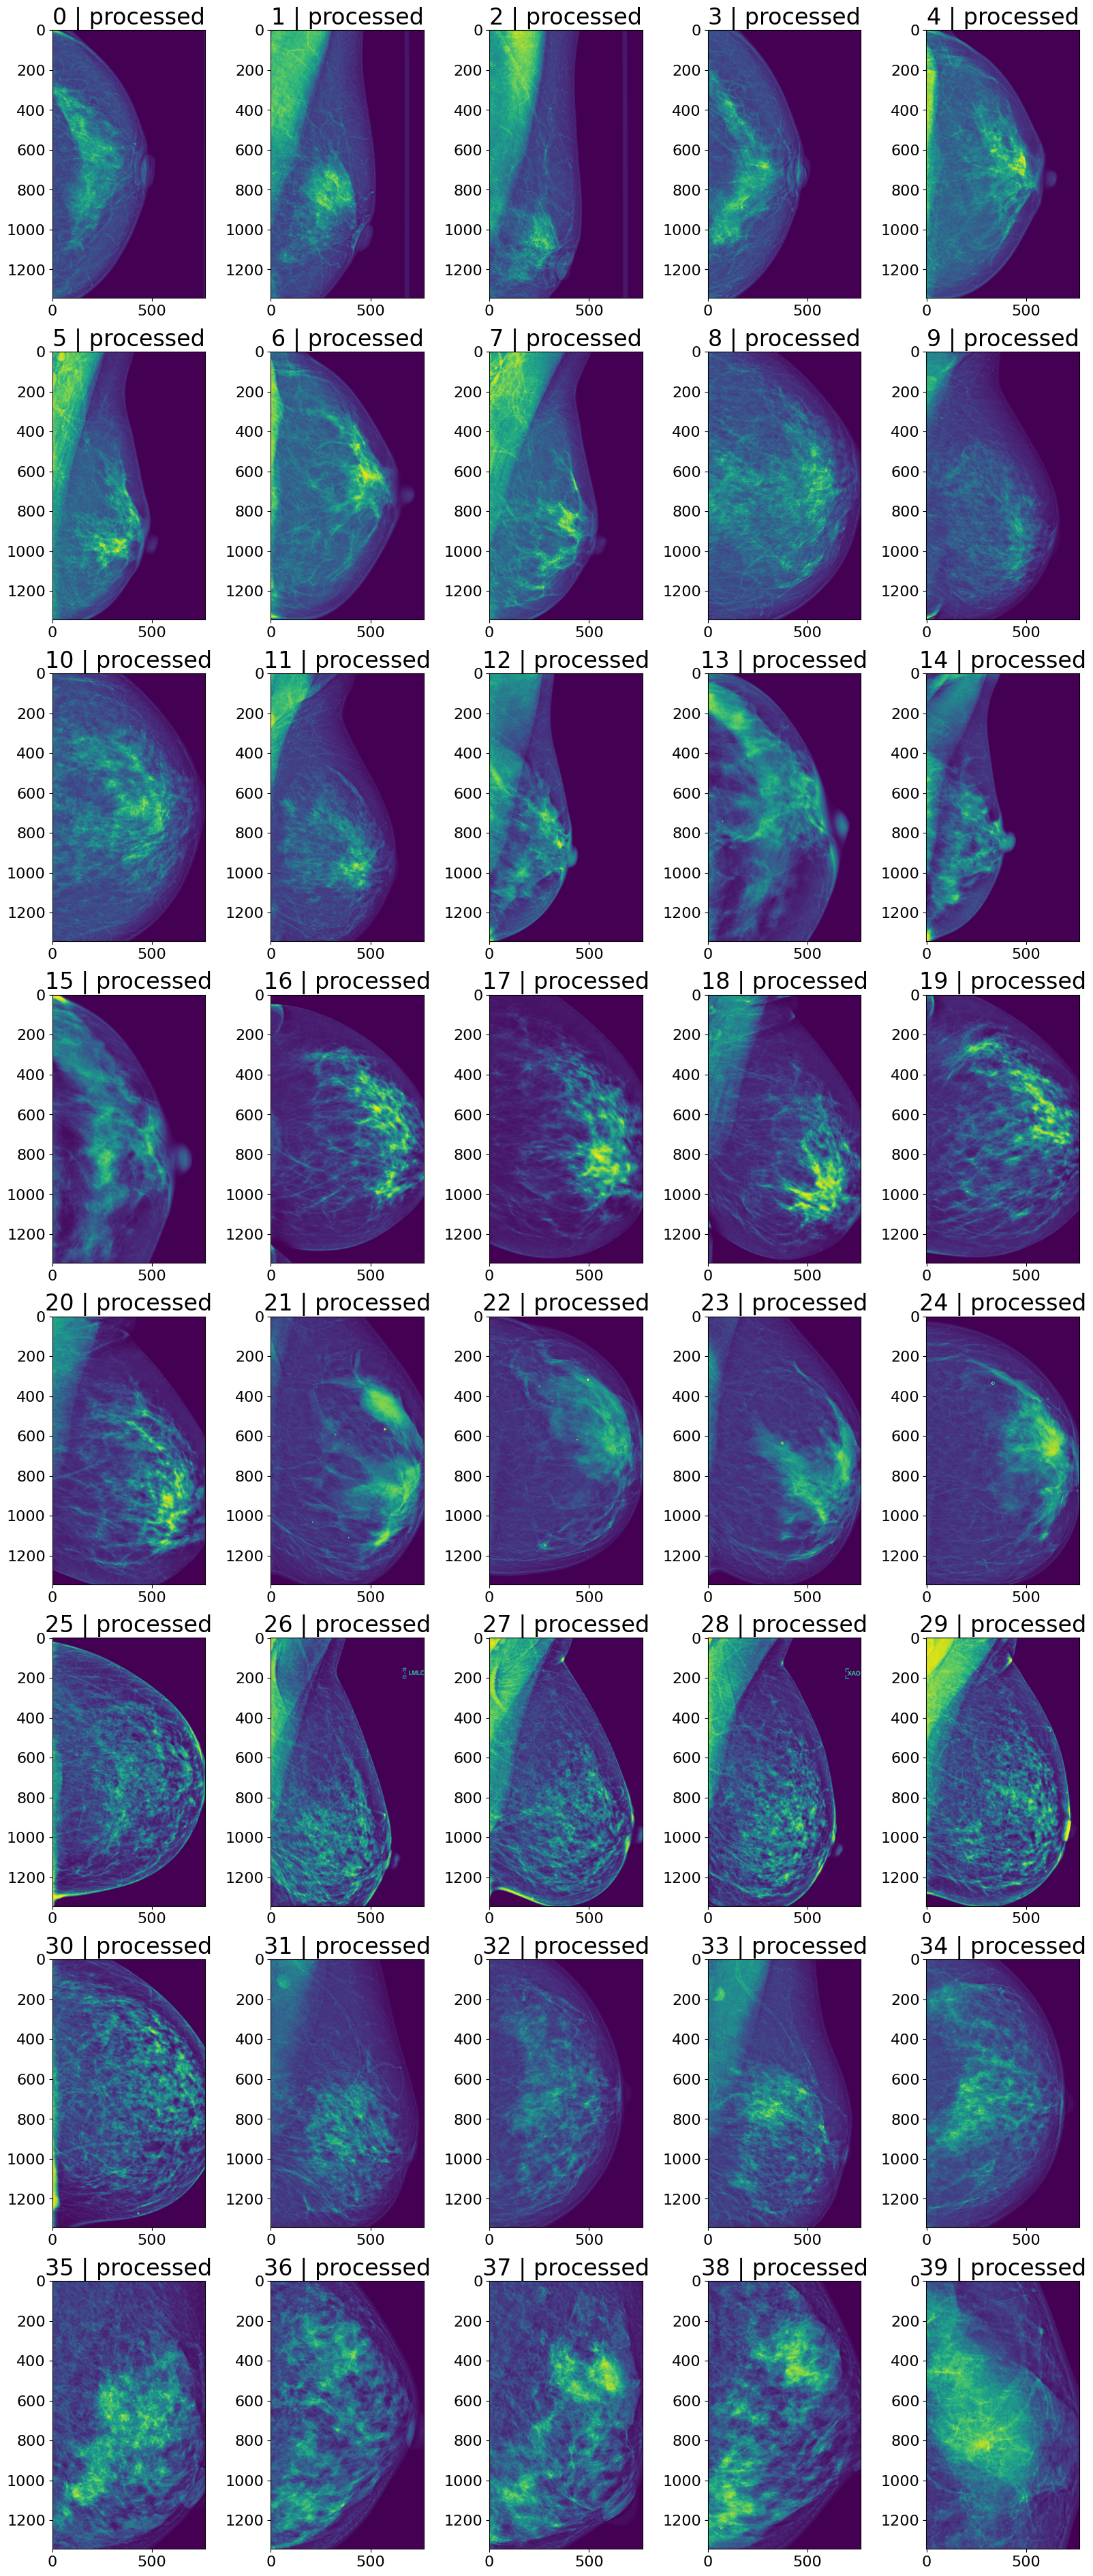

In [17]:
def plot_original_processed_examples(rows=48, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*6))
    for r in tqdm(range(rows)):
        for c in range(cols):
            idx = (r * cols) + c
            image = process(
                train.loc[idx, 'filepath'],
                crop_image=True,
                size=(int(os.environ['TARGET_WIDTH']), int(os.environ['TARGET_HEIGHT'])),
                apply_clahe=APPLY_CLAHE,
                apply_eq_hist=APPLY_EQ_HIST,
                debug=False
            )
            axes[r, c].imshow(image)
            axes[r, c].set_title(f'{idx} | processed')
    plt.show()
plot_original_processed_examples(rows=8)

In [18]:
for g_idx, g in tqdm(train.groupby('patient_id')):
    if 'CC' not in g['view'].values or 'MLO' not in g['view'].values:
        display(g)

  0%|          | 0/11913 [00:00<?, ?it/s]

In [19]:
PATIENT_ID_IMAGE_ID2CANCER = train.set_index(['patient_id', 'image_id'])['cancer'].to_dict()

In [21]:
test = pd.read_csv('../data/test.csv')
display(test.info())
display(test.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   site_id        4 non-null      int64 
 1   patient_id     4 non-null      int64 
 2   image_id       4 non-null      int64 
 3   laterality     4 non-null      object
 4   view           4 non-null      object
 5   age            4 non-null      int64 
 6   implant        4 non-null      int64 
 7   machine_id     4 non-null      int64 
 8   prediction_id  4 non-null      object
dtypes: int64(6), object(3)
memory usage: 416.0+ bytes


None

site_id  patient_id    image_id laterality view  age  implant  machine_id  \
0        2       10008   736471439          L  MLO   81        0          21   
1        2       10008  1591370361          L   CC   81        0          21   
2        2       10008    68070693          R  MLO   81        0          21   

  prediction_id  
0       10008_L  
1       10008_L  
2       10008_R

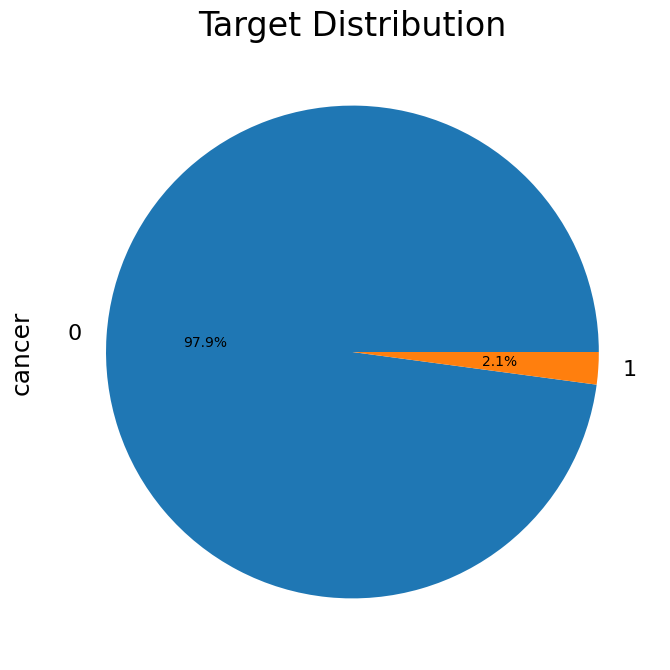

In [22]:
plt.figure(figsize=(8, 8))
train['cancer'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Target Distribution')
plt.show()

In [24]:
FOLDER_PATHS = glob.glob('../train_images/*')
print(f"Found {len(FOLDER_PATHS)} train folders")

Found 11913 train folders


In [25]:
FILE_PATHS = glob.glob('../train_images/*/*.dcm')
print(f'Found {len(FILE_PATHS)} Train Files')

Found 54706 Train Files


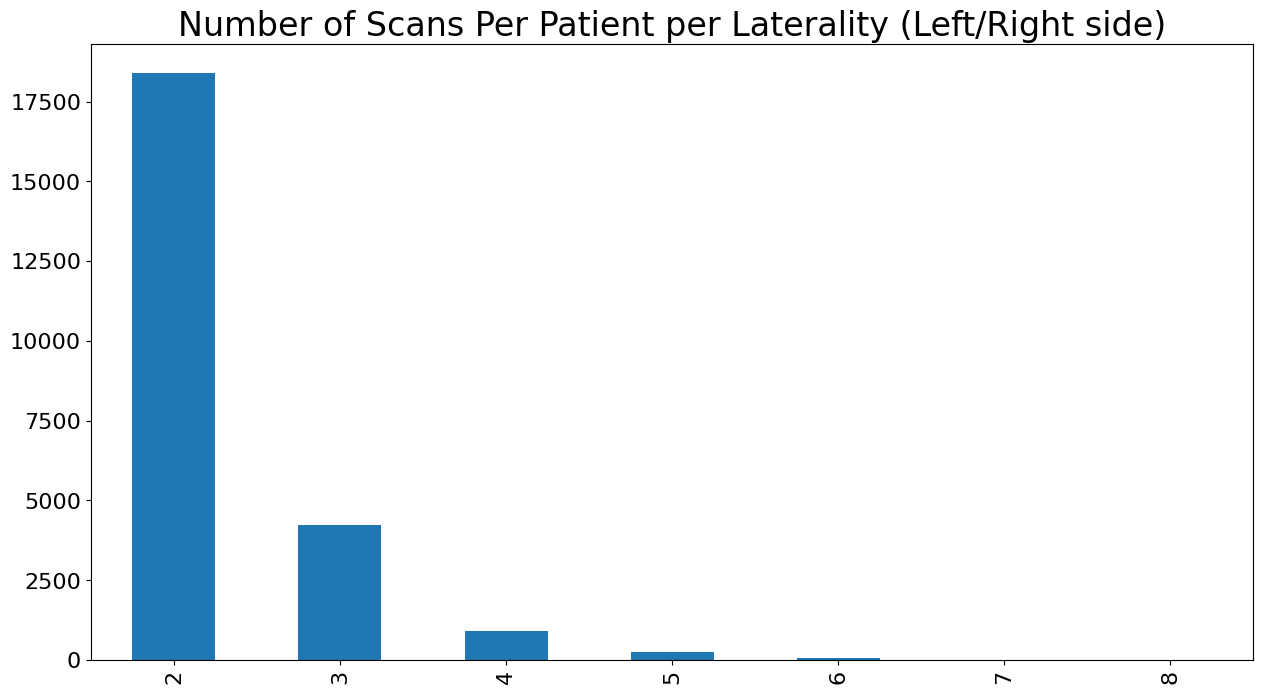

In [26]:
plt.figure(figsize=(15,8))
plt.title('Number of Scans Per Patient per Laterality (Left/Right side)')
train.groupby(['patient_id', 'laterality']).apply(len).value_counts().sort_index().plot(kind='bar')
plt.show()

In [27]:
# Scan View Counts: most patient only have a CC and MLO scan
display(train.sort_values('view').groupby(['patient_id', 'laterality'])['view'].apply(tuple).value_counts().to_frame('Count'))

Count
(CC, MLO)                                18384
(CC, MLO, MLO)                            2599
(CC, CC, MLO)                             1606
(CC, CC, MLO, MLO)                         795
(CC, CC, MLO, MLO, MLO)                    161
(CC, CC, CC, MLO, MLO)                      71
(CC, MLO, MLO, MLO)                         60
(CC, CC, CC, MLO, MLO, MLO)                 46
(CC, CC, CC, MLO)                           44
(AT, CC, MLO)                               10
(CC, LM, MLO)                                8
(CC, CC, CC, MLO, MLO, MLO, MLO)             7
(CC, CC, MLO, MLO, MLO, MLO)                 7
(CC, ML, MLO)                                4
(CC, CC, CC, CC, MLO, MLO)                   3
(CC, MLO, MLO, MLO, MLO)                     3
(AT, CC, CC, MLO)                            2
(AT, CC, CC, CC, MLO, MLO)                   2
(CC, CC, CC, CC, MLO, MLO, MLO)              2
(CC, MLO, MLO, MLO, MLO, MLO, MLO, MLO)      1
(CC, CC, CC, CC, MLO, MLO, MLO, MLO)         1
(CC, CC, CC, ML, MLO, MLO)                   1
(CC, CC, CC, LM, MLO, MLO)                   1
(AT, AT, CC, MLO, MLO)                       1
(AT, CC, CC, CC, MLO, MLO, MLO)              1
(CC, LMO, MLO, MLO)                          1
(CC, CC, ML, ML, MLO)                        1
(AT, CC, CC, MLO, MLO)                       1
(AT, CC, MLO, MLO)                           1
(CC, CC, ML, MLO, MLO)                       1
(CC, CC, LM, MLO)                            1

  0%|          | 0/16 [00:00<?, ?it/s]

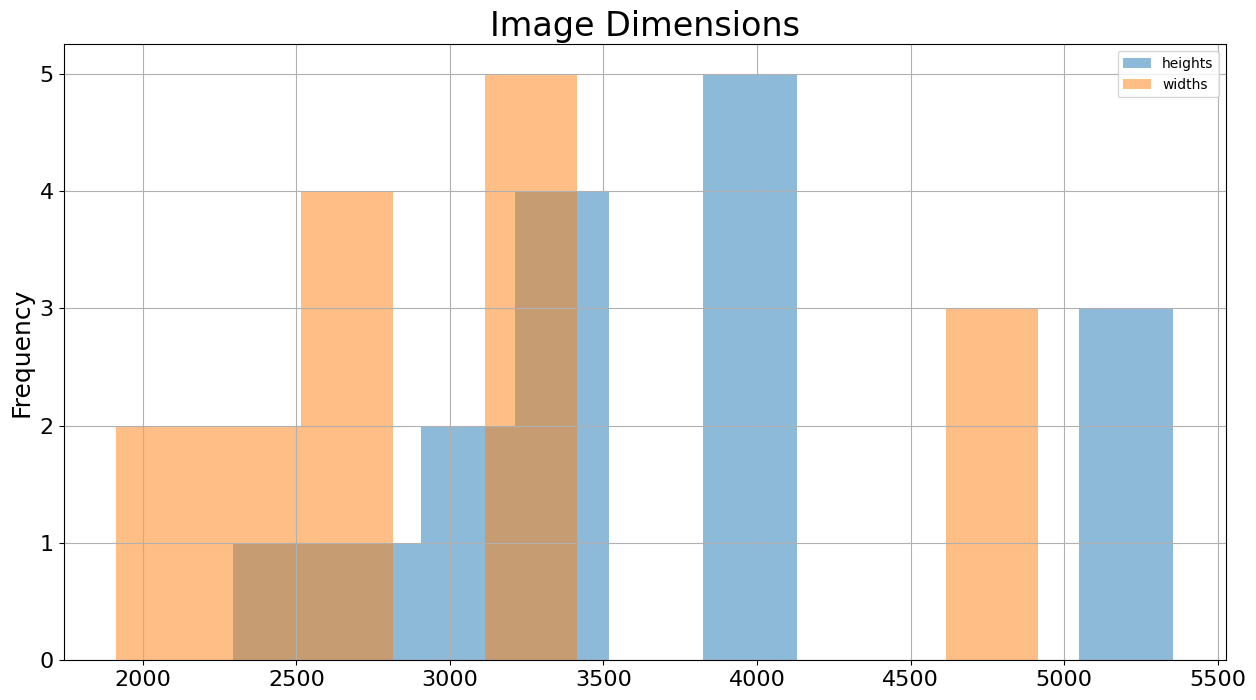

In [28]:
# Get height/width statistics
N = 16
WIDTHS = []
HEIGHTS = []
for fp in tqdm(np.random.choice(FILE_PATHS, N)):
    h, w = process(fp).shape
    HEIGHTS.append(h)
    WIDTHS.append(w)
# Patches are insanely huge!
plt.figure(figsize=(15,8))
plt.title('Image Dimensions', size=24)
pd.Series(HEIGHTS).plot(kind='hist', alpha=0.50, label='heights')
pd.Series(WIDTHS).plot(kind='hist', alpha=0.50, label='widths')
plt.grid()
plt.legend()
plt.show()

Height/Width Ratio's
count             16.000000
mean               1.232022
std                0.079673
min                1.089522
25%                1.222711
50%                1.230769
75%                1.300000
max                1.333333

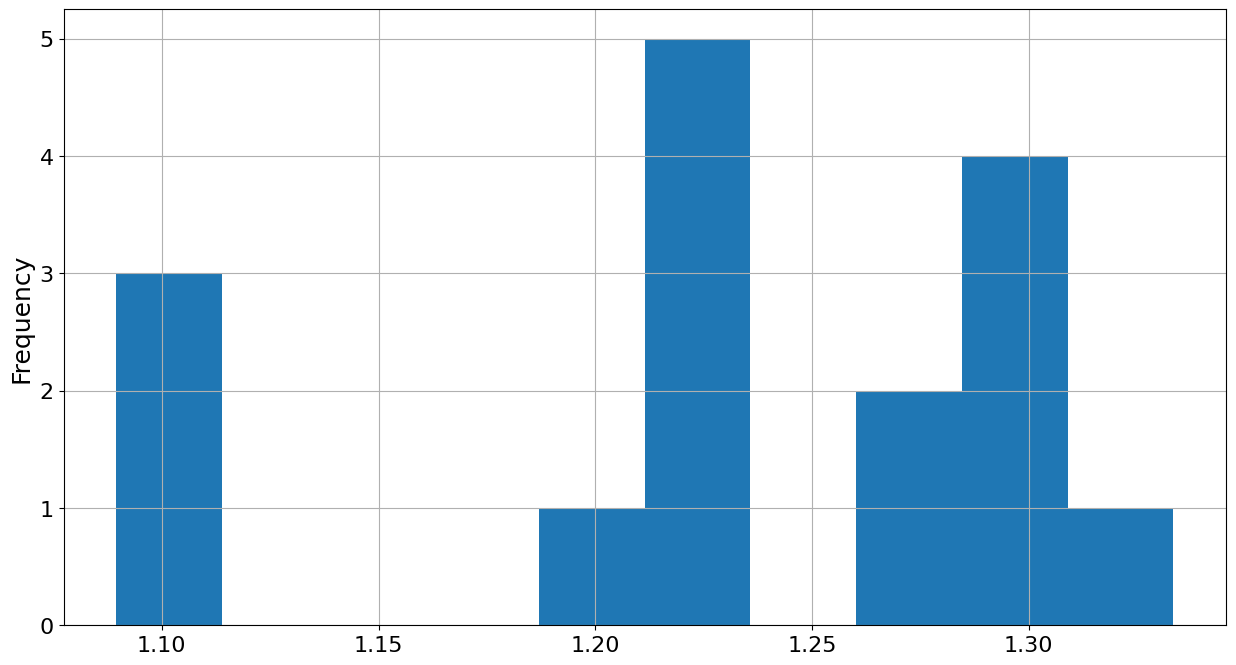

In [29]:
# Height to Width Ratio's, height is roughly 1.25x width, that's why resize to (512*1.25)x512 = 640x512
display(pd.Series(np.array(HEIGHTS) / np.array(WIDTHS)).describe().to_frame('Height/Width Ratio\'s'))

plt.figure(figsize=(15,8))
pd.Series(np.array(HEIGHTS) / np.array(WIDTHS)).plot(kind='hist')
plt.grid()
plt.show()

In [30]:
SEED = int(os.environ['SEED'])
np.random.seed(SEED)

N = 16
WIDTHS_CROPPED = []
HEIGHTS_CROPPED = []

for fp in tqdm(np.random.choice(FILE_PATHS, N)):
    h, w = process(fp, crop_image=True).shape
    WIDTHS_CROPPED.append(h)
    HEIGHTS_CROPPED.append(w)

  0%|          | 0/16 [00:00<?, ?it/s]

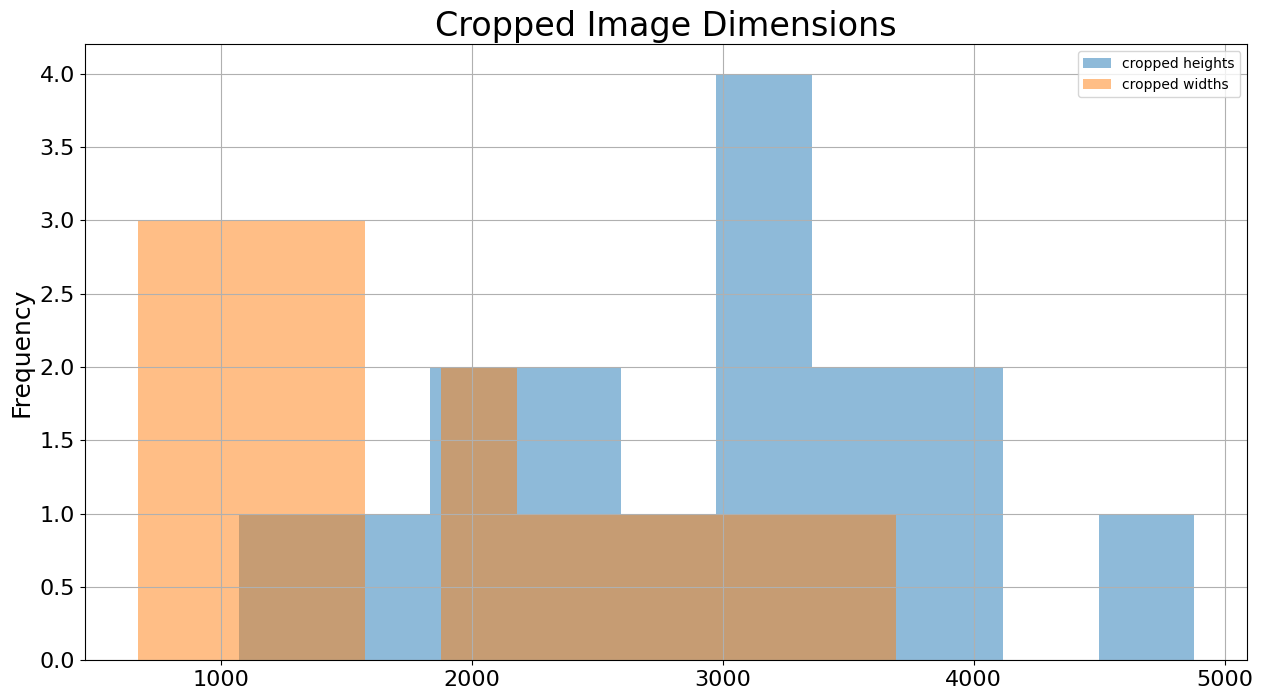

In [31]:
plt.figure(figsize=(15,8))
plt.title('Cropped Image Dimensions', size=24)
pd.Series(WIDTHS_CROPPED).plot(kind='hist', alpha=0.50, label='cropped heights')
pd.Series(HEIGHTS_CROPPED).plot(kind='hist', alpha=0.50, label='cropped widths')
plt.grid()
plt.legend()
plt.show()

Cropped Height/Width Ratio's
count                     16.000000
mean                       1.803504
std                        0.494154
min                        1.154095
25%                        1.357186
50%                        1.684643
75%                        2.212829
max                        2.629883

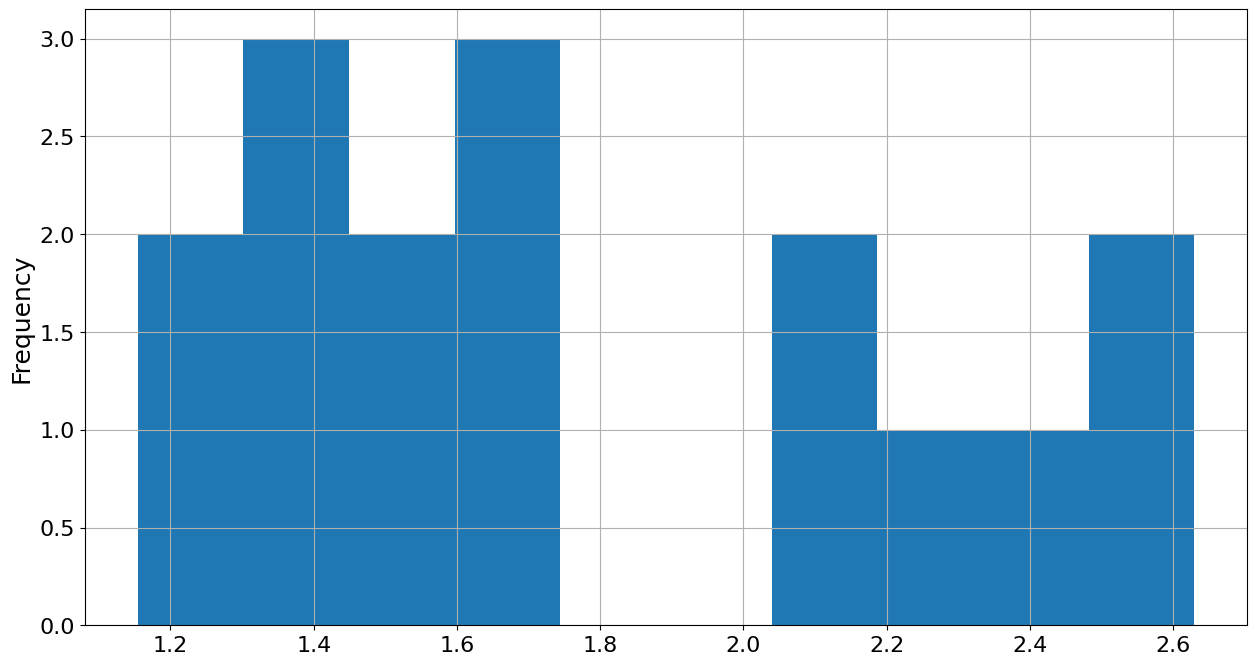

In [32]:
# Height to Width Ratio's
display(pd.Series(np.array(WIDTHS_CROPPED) / np.array(HEIGHTS_CROPPED)).describe().to_frame('Cropped Height/Width Ratio\'s'))
plt.figure(figsize=(15,8))
pd.Series(np.array(WIDTHS_CROPPED) / np.array(HEIGHTS_CROPPED)).plot(kind='hist')
plt.grid()
plt.show()

In [33]:
# Make Pairs of Views as input to the model
FILE_PATHS_PAIRS = []
for row_idx, row in tqdm(train.iterrows(), total=len(train)):
        FILE_PATHS_PAIRS.append(row[['patient_id', 'image_id']].values)
        
FILE_PATHS_PAIRS = np.array(FILE_PATHS_PAIRS, dtype=object)
print(f'FILE_PATHS_PAIRS shape: {FILE_PATHS_PAIRS.shape}')

  0%|          | 0/54706 [00:00<?, ?it/s]

FILE_PATHS_PAIRS shape: (54706, 2)


In [34]:
# Put every image in a seperate TFRecord file
N_CHUNKS = 100
CHUNKS = np.array_split(FILE_PATHS_PAIRS, N_CHUNKS)

print(f'N_CHUNKS: {N_CHUNKS}, CHUNK len: {len(CHUNKS[0])}, shape: {CHUNKS[0].shape}')

N_CHUNKS: 100, CHUNK len: 548, shape: (548, 2)


In [39]:
# Single sample processing
def process_chunk(args):
    patient_id, image_id = args
    # Define file path
    fp = f'train_images/{patient_id}/{image_id}.dcm'
    # Get processed image and target
    image, target = process(fp, size=(TARGET_WIDTH, TARGET_HEIGHT), ret_target=True, crop_image=True)

    # Make grayscale channel
    image = np.expand_dims(image, 2)
    
    # Encode PNG
    if IMAGE_FORMAT == 'PNG':
        image_serialized = tf.io.encode_png(image, compression=9).numpy()
    # Encode JPEG
    else:
        image_serialized = tf.io.encode_jpeg(image, quality=IMAGE_QUALITY, optimize_size=True).numpy()
    
    return image_serialized, target, patient_id, image_id

def to_tf_records(chunks):
    for chunk_idx, chunk in enumerate(tqdm(chunks)):
        print(f'===== GENERATING TFRECORDS {chunk_idx} =====')
        tfrecord_name = f'batch_{chunk_idx}.tfrecords'
        
        # Create the actual TFRecords
        options = tf.io.TFRecordOptions(compression_type='GZIP', compression_level=9)
        with tf.io.TFRecordWriter(tfrecord_name, options=options) as file_writer:
            # Process Samples in Chunk in Parallell
            jobs = [joblib.delayed(process_chunk)(args) for args in chunk]
            chunk_processed = joblib.Parallel(
                n_jobs=cpu_count(),
                verbose=0,
                backend='multiprocessing',
                prefer='threads',
            )(jobs)
            
            # Add Processed Samples to TFRecord
            for image, target, patient_id, image_id in chunk_processed:
                record_bytes = tf.train.Example(features=tf.train.Features(feature={
                    # Image
                    'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),

                    # target
                    'target': tf.train.Feature(int64_list=tf.train.Int64List(value=[target])),
                    
                    # patient_id
                    'patient_id': tf.train.Feature(int64_list=tf.train.Int64List(value=[patient_id])),
                    
                    # image_id
                    'image_id': tf.train.Feature(int64_list=tf.train.Int64List(value=[image_id])),
                })).SerializeToString()
                file_writer.write(record_bytes)

In [40]:
to_tf_records(CHUNKS[:10])

  0%|          | 0/10 [00:00<?, ?it/s]

===== GENERATING TFRECORDS 0 =====


2023-02-03 20:18:09.184260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:
2023-02-03 20:18:09.184352: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-03 20:18:09.184393: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-1): /proc/driver/nvidia/version does not exist
2023-02-03 20:18:09.186227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:
2023-02-03 20:18:09.186305: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] fail

In [ ]:
def decode_tfrecord(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.int64),
        'patient_id': tf.io.FixedLenFeature([], tf.int64),
        'image_id': tf.io.FixedLenFeature([], tf.int64),
    })
        
    if IMAGE_FORMAT == 'PNG':
        image = tf.io.decode_png(features['image'], channels=N_CHANNELS)
    else:
        image = tf.io.decode_jpeg(features['image'], channels=N_CHANNELS)
        
    image = tf.reshape(image, [TARGET_HEIGHT, TARGET_WIDTH, N_CHANNELS])

    target = features['target']
    patient_id = features['patient_id']
    image_id = features['image_id']
    
    return image, target, patient_id, image_id

# Sample TFRecord Dataset
def get_train_dataset():
    # Read all TFRecord file paths
    FNAMES_TRAIN_TFRECORDS = tf.io.gfile.glob('./*.tfrecords')
    # initialize TFRecord dataset
    train_dataset = tf.data.TFRecordDataset(FNAMES_TRAIN_TFRECORDS, num_parallel_reads=1, compression_type='GZIP')
    # Decode samples by mapping with decode function
    train_dataset = train_dataset.map(decode_tfrecord)
    # Batch samples
    train_dataset = train_dataset.batch(N)
    
    return train_dataset

# Shows a batch of images
def show_batch(dataset, rows=N, cols=1):
    images, targets, patient_ids, image_ids = next(iter(dataset))
    images = np.moveaxis(images, 3, 1)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6, rows*10))
    for r in range(rows):
        for c in range(cols):
            img = images[r,c]
            axes[r].imshow(img)
            if c == 0:
                target = targets[r]
                patient_id = patient_ids[r]
                image_id = image_ids[r]
                axes[r].set_title(f'target: {target}, patient_id: {patient_id}, image_id: {image_id}', fontsize=12, pad=16)
        
    plt.show()

In [ ]:
N = 16
# Show Example Batch
train_dataset = get_train_dataset()
show_batch(train_dataset)